Importation et configuration des sources de données Kaggle

In [1]:

import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


Data source import complete.


Configuration de l’environnement et exploration des fichiers de données

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1157.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0125.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0699.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1273.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0374.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1370.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1171.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1484.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0816.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0085.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0029.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_1285.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0210.jpg
/kaggle/inpu

Définition des chemins d’accès aux dossiers d’entraînement et de test

In [3]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

Analyse et comptage des images par classe dans les dossiers d'entraînement et de test

In [4]:
import os


# Fonction pour compter les fichiers dans chaque sous-dossier
def count_images(directory):
    count_per_class = {}
    total = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            count_per_class[class_name] = num_images
            total += num_images
    return count_per_class, total

# Comptage des images
train_counts, train_total = count_images(train_dir)
test_counts, test_total = count_images(test_dir)

print("Nombre d'images dans le dossier d'entraînement :")
for cls, count in train_counts.items():
    print(f"{cls} : {count}")
print(f"Total : {train_total} images\n")

print("Nombre d'images dans le dossier de test :")
for cls, count in test_counts.items():
    print(f"{cls} : {count}")
print(f"Total : {test_total} images")


Nombre d'images dans le dossier d'entraînement :
pituitary : 1457
notumor : 1595
meningioma : 1339
glioma : 1321
Total : 5712 images

Nombre d'images dans le dossier de test :
pituitary : 300
notumor : 405
meningioma : 306
glioma : 300
Total : 1311 images


Chargement et préparation des jeux de données d'entraînement et de validation

In [4]:
import tensorflow as tf

BATCH_SIZE = 8
IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Testing',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


Visualiser des images du dataset d'entraînement

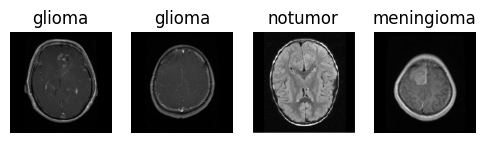

In [6]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):  # Prend le premier batch
    for i in range(4):  # Affiche les 8 images du batch
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


Optimisation du Pipeline de Données avec TensorFlow – Mise en Cache et Préchargement Automatique

In [6]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Définition du modèle EfficientNetB0 avec augmentation des données

In [5]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='pooling')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

final_model = tf.keras.models.Model(inputs, outputs)

final_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling                         │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,365,415 (20.47 MB)

 Trainable params: 5,323,392 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

Définition des callbacks personnalisés pour le contrôle de l'entraînement

In [6]:
from tensorflow.keras import callbacks

class StopOnValAccuracy(callbacks.Callback):
    def __init__(self, target=0.985):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\nReached {val_acc:.2%} val_accuracy — stopping training.")
            self.model.stop_training = True

# Define callbacks
callbacks = [
    # Early Stopping
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),

    # Learning Rate Reduction
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    StopOnValAccuracy(target=0.995)
]

Phase 1 : Entraînement avec le modèle de base gelé

In [7]:
# 1. Keep base model frozen
base_model.trainable = False

# 2. Compile with higher initial LR
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. First training phase
history_frozen = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,  # Use the callbacks you defined earlier
    verbose=1
)

Epoch 1/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7858 - loss: 0.5923 - val_accuracy: 0.8307 - val_loss: 0.4151 - learning_rate: 0.0010
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.8623 - loss: 0.3497 - val_accuracy: 0.8337 - val_loss: 0.3992 - learning_rate: 0.0010
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.8899 - loss: 0.2870 - val_accuracy: 0.8482 - val_loss: 0.3581 - learning_rate: 0.0010
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9012 - loss: 0.2560 - val_accuracy: 0.8924 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9124 - loss: 0.2427 - val_accuracy: 0.8535 - val_loss: 0.3753 - learning_rate: 0.0010
Epoch 6/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9170 - loss: 0.2226 - val_accuracy: 0.8795 - val_loss: 0.3078 - learning_rate: 0.0010
Epoch 7/10
712/714 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9209 - lo

Phase 2 : Fine-tuning partiel du modèle EfficientNetB0

In [8]:
# 1. Débloquer partiellement le base_model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# 2. Recompiler avec LR plus bas
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Définir callbacks fine tuning
fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# 4. Lancer fine-tuning
history_fine_tune = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    initial_epoch=history_frozen.epoch[-1] + 1,
    callbacks=fine_tune_callbacks,
    verbose=1
)


Epoch 11/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.8225 - loss: 0.6088 - val_accuracy: 0.9054 - val_loss: 0.2587 - learning_rate: 1.0000e-04
Epoch 12/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 78s 71ms/step - accuracy: 0.9215 - loss: 0.2130 - val_accuracy: 0.9283 - val_loss: 0.1979 - learning_rate: 1.0000e-04
Epoch 13/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - accuracy: 0.9462 - loss: 0.1526 - val_accuracy: 0.9542 - val_loss: 0.1214 - learning_rate: 1.0000e-04
Epoch 14/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 51s 71ms/step - accuracy: 0.9538 - loss: 0.1279 - val_accuracy: 0.9664 - val_loss: 0.0915 - learning_rate: 1.0000e-04
Epoch 15/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - accuracy: 0.9659 - loss: 0.0963 - val_accuracy: 0.9519 - val_loss: 0.2125 - learning_rate: 1.0000e-04
Epoch 16/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 84s 72ms/step - accuracy: 0.9694 - loss: 0.0791 - val_accuracy: 0.9733 - val_loss: 0.0786 - learning_rate: 1.0000e-04
Epoch 17/60
714/714 ━━━━━━━━━━━━━━━━━━━━ 80s 6

Visualisation des courbes d’accuracy et de loss pendant l’entraînement et le fine-tuning

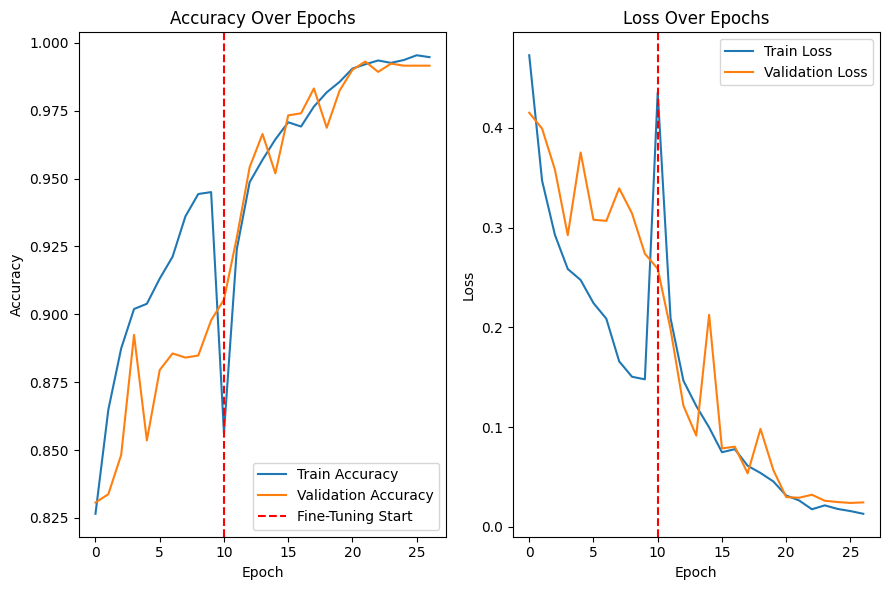

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history_frozen, history_fine_tune=None):
    plt.figure(figsize=(9, 6))

    # Combine histories if fine-tuning was done
    if history_fine_tune:
        for key in history_frozen.history:
            history_frozen.history[key] += history_fine_tune.history[key]

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_frozen.history['accuracy'], label='Train Accuracy')
    plt.plot(history_frozen.history['val_accuracy'], label='Validation Accuracy')
    if history_fine_tune:
        plt.axvline(len(history_frozen.history['accuracy']) - len(history_fine_tune.history['accuracy']),
                   color='red', linestyle='--', label='Fine-Tuning Start')
    plt.title('Accuracy Over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_frozen.history['loss'], label='Train Loss')
    plt.plot(history_frozen.history['val_loss'], label='Validation Loss')
    if history_fine_tune:
        plt.axvline(len(history_frozen.history['loss']) - len(history_fine_tune.history['loss']),
                   color='red', linestyle='--')
    plt.title('Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot both phases
plot_training_history(history_frozen, history_fine_tune)

Évaluation du modèle : Rapport de classification sur l’ensemble de validation

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred_probs = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(final_model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Check if labels are one-hot encoded
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(
    y_true,
    y_pred,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     0.9933    0.9933    0.9933       300
           1     0.9967    0.9804    0.9885       306
           2     0.9975    1.0000    0.9988       405
           3     0.9836    0.9967    0.9901       300

    accuracy                         0.9931      1311
   macro avg     0.9928    0.9926    0.9927      1311
weighted avg     0.9932    0.9931    0.9931      1311



Analyse des Performances : Matrice de Confusion pour le Modèle de Classification

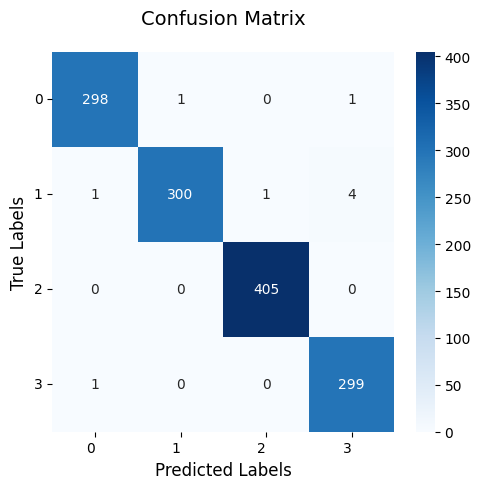

In [16]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure
    plt.figure(figsize=(5, 5))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)

    # Add labels and title
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, pad=20)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Usage with your TensorFlow dataset
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())

    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))


plot_confusion_matrix(y_true, y_pred, )

 Visualisation des Prédictions du Modèle sur des Images de Validation

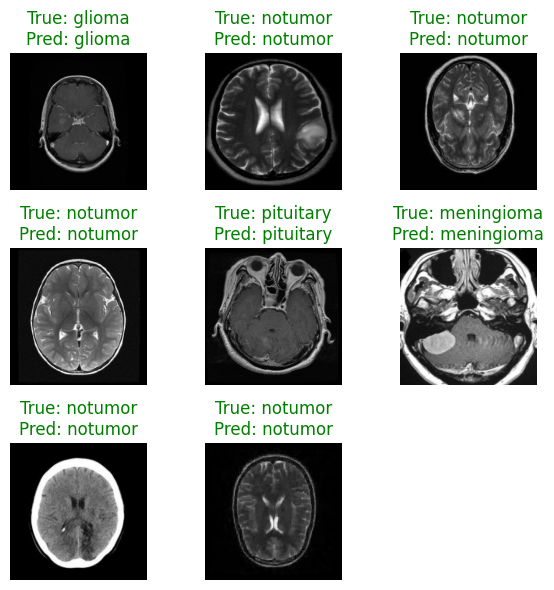

In [18]:
def plot_predictions(model, dataset, class_names, num_images=9):
    plt.figure(figsize=(6, 6))

    # Take one batch from the dataset
    for images, labels in dataset.take(2):
        # Make predictions
        preds = final_model.predict(images, verbose=0)
        pred_classes = np.argmax(preds, axis=1)

        # Convert one-hot labels if needed
        if len(labels.shape) > 1:
            true_classes = np.argmax(labels.numpy(), axis=1)
        else:
            true_classes = labels.numpy()

        # Plot images
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))

            # Set title with color coding
            true_label = class_names[true_classes[i]]
            pred_label = class_names[pred_classes[i]]

            color = 'green' if true_label == pred_label else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Usage
plot_predictions(final_model, val_ds, class_names)

Sauvegarde du Modèle Entraîné au Format H5

In [20]:
final_model.save('efficientnet_brain_tumor_model.h5')
print("Modèle sauvegardé au format H5.")


Modèle sauvegardé au format H5.
